In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
#!pip install pygam
#from pygam import LinearGAM

In [29]:
# load in dataset
# read in UK t2m & NAO data
df = pd.read_csv("ERA5_hourly_UK.csv")
df.columns = ["date_time","t2m","ssrd","msl","nao", "w10","w100", "tcc", "tp"]
df.head()

,date_time,t2m,ssrd,msl,nao,w10,w100,tcc,tp
0,1979-01-01 00:00:00,-5.702784,-32767.0,1014.010319,-1.38,0.539450,1.686726,0.596991,-32767000.0
1,1979-01-01 01:00:00,-5.507162,-32767.0,1014.724101,-1.38,0.756348,1.752340,0.616364,-32767000.0
2,1979-01-01 02:00:00,-5.664224,-32767.0,1015.209416,-1.38,1.106655,2.131312,0.609257,-32767000.0
3,1979-01-01 03:00:00,-5.944852,-32767.0,1015.758926,-1.38,1.299900,2.487398,0.633477,-32767000.0
4,1979-01-01 04:00:00,-5.952020,-32767.0,1015.954954,-1.38,1.383135,2.694151,0.638393,-32767000.0


In [30]:
# add week
df["week"] = pd.to_numeric(pd.to_datetime(df.date_time).dt.strftime("%U"))

# Preprocessing

### Split Train/test

In [31]:
# calculate daily values
df.date_time = pd.to_datetime(df.date_time)
df_daily = df.groupby(df.date_time.dt.date).mean()
df_daily["t2mmax"] = t2mmax = df.t2m.groupby(df.date_time.dt.date).max()
df_daily["t2mmin"] = df.t2m.groupby(df.date_time.dt.date).min()

# set X equal to df_daily
X = df_daily


In [32]:
# add principal components of mslp
df_pc_daily = pd.read_csv("ERA5_MSLP_anom_EOF_principal_component_daily.csv")
df_pc_daily.columns = ["date", "pc0", "pc1", "pc2", "pc3", "pc4"]
df_pc_daily.index = df_daily.index
df_pc_daily.drop(columns = ["date"], inplace = True)
df_pc_daily.head()

,pc0,pc1,pc2,pc3,pc4
date_time,,,,,
1979-01-01,-1090.45150,164.902330,-1298.45040,877.35504,-68.026290
1979-01-02,-1309.35950,-100.040955,-737.69104,524.54390,-340.954220
1979-01-03,-993.42834,637.372860,-466.08914,83.97379,-23.544626
1979-01-04,-1379.43630,744.881500,-855.41626,335.35236,858.638550
1979-01-05,-1225.06920,-224.592100,99.33860,780.53217,398.099400


In [33]:
# add principal components of mslp
X = pd.concat([df_daily, df_pc_daily], axis = 1)
X.head()

,t2m,ssrd,msl,nao,w10,w100,tcc,tp,week,t2mmax,t2mmin,pc0,pc1,pc2,pc3,pc4
date_time,,,,,,,,,,,,,,,,
1979-01-01,-4.159642,-9531.855820,1018.727490,-1.38,1.642102,3.302241,0.675312,-9.557042e+06,0,-2.207358,-5.952020,-1090.45150,164.902330,-1298.45040,877.35504,-68.026290
1979-01-02,-1.011778,25.708586,1022.629712,-1.38,2.915822,4.989152,0.636231,1.278941e-01,0,0.282814,-2.470000,-1309.35950,-100.040955,-737.69104,524.54390,-340.954220
1979-01-03,-0.129076,25.569494,1013.880059,-1.38,4.747445,7.739491,0.857288,1.156470e-01,0,1.041230,-1.418395,-993.42834,637.372860,-466.08914,83.97379,-23.544626
1979-01-04,-0.641538,20.183029,1011.304354,-1.38,3.155913,5.060900,0.934392,1.415519e-01,0,0.469106,-2.098208,-1379.43630,744.881500,-855.41626,335.35236,858.638550
1979-01-05,-2.196899,25.340972,1021.575488,-1.38,2.858333,4.329928,0.825873,9.688382e-02,0,-0.880194,-4.261743,-1225.06920,-224.592100,99.33860,780.53217,398.099400


In [34]:
# add lag features
X["t2min_previous"] = X.t2mmin.shift(1)
X["t2m_previous"] = X.t2m.shift(1)
X["t2min_next"] = X.t2mmin.shift(-1)
X["t2m_next"] = X.t2m.shift(-1)
X["w10_previous"] = X.w10.shift(1)
X["w10_next"] = X.w10.shift(-1)
X["pc0_previous"] = X.pc0.shift(1)
X["pc0_next"] = X.pc0.shift(-1)
X["pc1_previous"] = X.pc0.shift(1)
X["pc1_next"] = X.pc0.shift(-1)
X["pc2_previous"] = X.pc0.shift(1)
X["pc2_next"] = X.pc0.shift(-1)
X["pc3_previous"] = X.pc0.shift(1)
X["pc3_next"] = X.pc0.shift(-1)
X["pc4_previous"] = X.pc0.shift(1)
X["pc4_next"] = X.pc0.shift(-1)
X = X.fillna(0)
X.head()

,t2m,ssrd,msl,nao,w10,w100,tcc,tp,week,t2mmax,...,pc0_previous,pc0_next,pc1_previous,pc1_next,pc2_previous,pc2_next,pc3_previous,pc3_next,pc4_previous,pc4_next
date_time,,,,,,,,,,,,,,,,,,,,,
1979-01-01,-4.159642,-9531.855820,1018.727490,-1.38,1.642102,3.302241,0.675312,-9.557042e+06,0,-2.207358,...,0.00000,-1309.35950,0.00000,-1309.35950,0.00000,-1309.35950,0.00000,-1309.35950,0.00000,-1309.35950
1979-01-02,-1.011778,25.708586,1022.629712,-1.38,2.915822,4.989152,0.636231,1.278941e-01,0,0.282814,...,-1090.45150,-993.42834,-1090.45150,-993.42834,-1090.45150,-993.42834,-1090.45150,-993.42834,-1090.45150,-993.42834
1979-01-03,-0.129076,25.569494,1013.880059,-1.38,4.747445,7.739491,0.857288,1.156470e-01,0,1.041230,...,-1309.35950,-1379.43630,-1309.35950,-1379.43630,-1309.35950,-1379.43630,-1309.35950,-1379.43630,-1309.35950,-1379.43630
1979-01-04,-0.641538,20.183029,1011.304354,-1.38,3.155913,5.060900,0.934392,1.415519e-01,0,0.469106,...,-993.42834,-1225.06920,-993.42834,-1225.06920,-993.42834,-1225.06920,-993.42834,-1225.06920,-993.42834,-1225.06920
1979-01-05,-2.196899,25.340972,1021.575488,-1.38,2.858333,4.329928,0.825873,9.688382e-02,0,-0.880194,...,-1379.43630,-304.30496,-1379.43630,-304.30496,-1379.43630,-304.30496,-1379.43630,-304.30496,-1379.43630,-304.30496


In [35]:
# create 24-hour t2m arrays as target variable
Y_list = []
for i in range(int(len(df)/24)):
    Y_list.append(df.w10.iloc[(i*24):(i*24+24)].values)
Y = np.array(Y_list)

# add date_time index
y = pd.DataFrame(Y,index=df_daily.index)

### Visualization of independent vars

In [36]:
#X.hist(figsize=(10,6))

Mostly normal distributions of variables of interest, except ssrd. 

In [37]:
#df.ssrd.plot(figsize=(10,5))

Remove outlier from ssrd.

In [38]:
# remove outliers
#X.ssrd[X.ssrd<-5000]=0

# produce ssrd plot
#X.ssrd.hist()



Split train/test

In [39]:
# split train/test 70/30
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state = 10,shuffle=False)

# create a dataframe of the hours for plotting purposes
X_test.index = pd.to_datetime(X_test.index)
X_test_hours = X_test.resample("1H").pad().index

### Modeling

Linear Regression

In [40]:
from sklearn.linear_model import LinearRegression

# produce linear regression
reg = LinearRegression().fit(X_train, y_train)
pred_reg = reg.predict(X_test)

In [41]:
# metrics
r2_reg = r2_score(y_test,pred_reg)
mae_reg = mean_absolute_error(y_test,pred_reg)
mse_reg = mean_squared_error(y_test,pred_reg)


print("R2-score: ",r2_reg)
print("MAE-score: ",mae_reg)
print("MSE-score: ",mse_reg)



R2-score:  0.8991170698683839
MAE-score:  0.4832598435500859
MSE-score:  0.42975744089972273


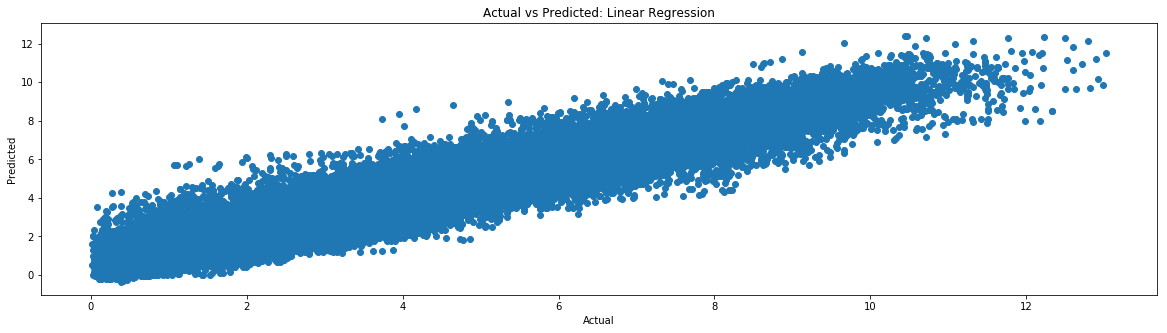

In [42]:
# plot results
plt.scatter(y_test.values.flatten(),pred_reg.flatten())
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted: Linear Regression")
plt.rcParams["figure.figsize"] = (20,5)

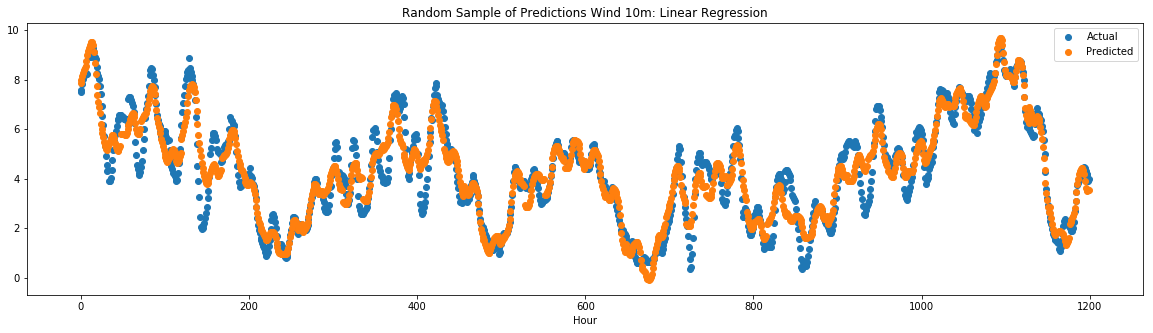

In [43]:
plt.scatter(np.arange(0,50*24,1),y_test.values[300:350])
plt.scatter(np.arange(0,50*24,1),pred_reg[300:350])
plt.xlabel("Hour")
plt.title("Random Sample of Predictions Wind 10m: Linear Regression")
plt.legend(["Actual","Predicted"])

# Random Forest

In [50]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100).fit(X_train,y_train)
pred_rf = rf.predict(X_test)

In [51]:
# metrics
r2_rf = r2_score(y_test,pred_rf)
mae_rf = mean_absolute_error(y_test,pred_rf)
mse_rf = mean_squared_error(y_test,pred_rf)

print("R2-score: ",r2_rf)
print("MAE-score: ",mae_rf)
print("MSE-score: ",mse_rf)

R2-score:  0.8886703738365895
MAE-score:  0.5038970992053938
MSE-score:  0.47400970643402146


In [52]:
# n_estimators = []
# mae = []
# mse = []
# for i in range(1,40,10):
#     rf = RandomForestRegressor(n_estimators=i).fit(X_train,y_train)
#     pred_rf = rf.predict(X_test)
#     n_estimators.append(i)
#     mae.append(mean_absolute_error(y_test,pred_rf)) 
#     mse.append(mean_squared_error(y_test,pred_rf)) 
# n_estimators = np.array(n_estimators)
# mae = np.array(mae)
# mse = np.array(mse)

# plt.plot(n_estimators,mae)
# plt.title("Scree Plot: Random Forest")
# plt.xlabel("n_estimators")
# plt.ylabel("MAE")

# plt.plot(n_estimators,mse)
# plt.title("Scree Plot: Random Forest")
# plt.xlabel("n_estimators")
# plt.ylabel("MSE")

Maximum number of trees can be set to 100 as there is little computational cost.

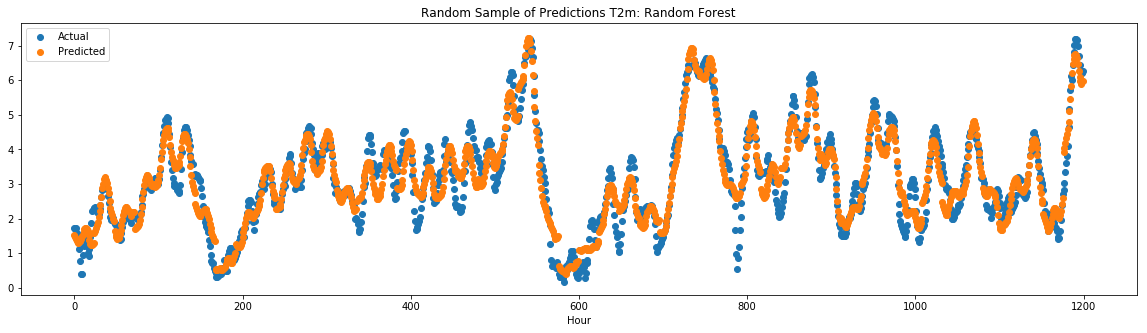

In [53]:
plt.scatter(np.arange(0,50*24,1),y_test.values[4000:4050])
plt.scatter(np.arange(0,50*24,1),pred_rf[4000:4050])
plt.xlabel("Hour")
plt.title("Random Sample of Predictions T2m: Random Forest")
plt.legend(["Actual","Predicted"])

### Analyze Best Performer

The best performer was Gradient Boosting. 

Below is a visual representation of the seasonal error.

Text(0, 0.5, 'MSE')

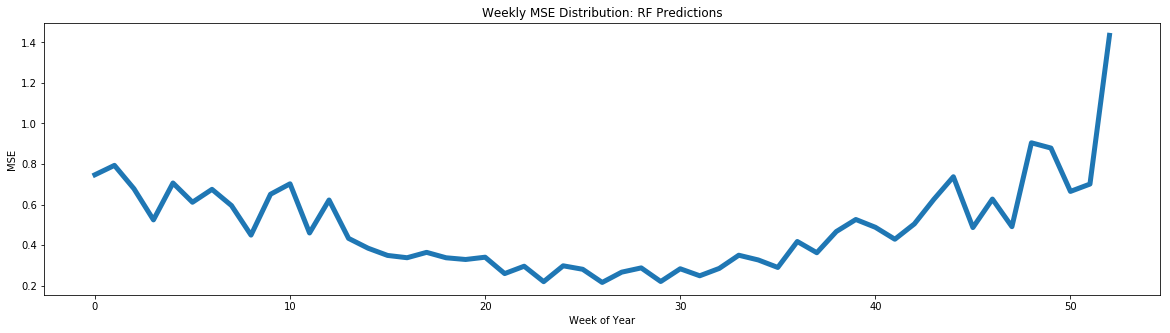

In [54]:
se = (pred_rf - y_test)**2
se.index = pd.to_datetime(se.index)
mse_by_week = se.groupby(se.index.week).mean().mean(axis=1)
plt.plot(np.arange(0,53,1),mse_by_week.values.flatten(),linewidth=5)
plt.title("Weekly MSE Distribution: RF Predictions")
plt.xlabel("Week of Year")
plt.ylabel("MSE")

Text(0, 0.5, 'MSE')

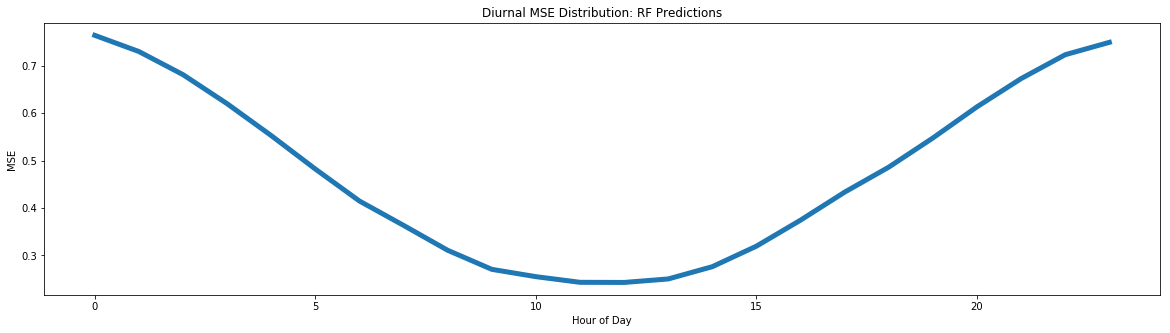

In [55]:
se = (pred_rf - y_test)**2
se.index = pd.to_datetime(se.index)
mse_by_hour = se.groupby(se.index.hour).mean()
plt.plot(np.arange(0,24,1),mse_by_hour.values.flatten(),linewidth=5)
plt.title("Diurnal MSE Distribution: RF Predictions")
plt.xlabel("Hour of Day")
plt.ylabel("MSE")

Found that winter weeks have higher MSE in comparison to summer months.

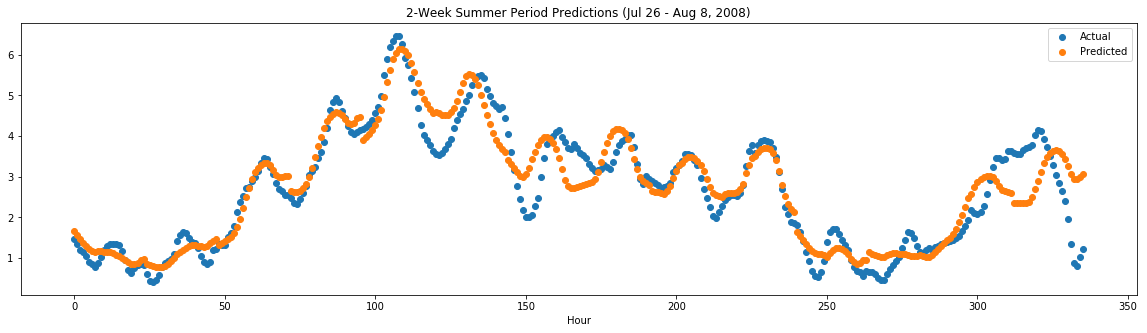

In [56]:
# generate summer/winter comparisons
y_d14_summer = y_test.iloc[60:74]
y_d14_winter = y_test.iloc[230:244]
pred_d14_summer = pred_rf[60:74]
pred_d14_winter = pred_rf[230:244]

plt.scatter(np.arange(0,14*24,1),y_d14_summer)
plt.scatter(np.arange(0,14*24,1),pred_d14_summer)
plt.xlabel("Hour")
plt.title("2-Week Summer Period Predictions (Jul 26 - Aug 8, 2008)")
plt.legend(["Actual","Predicted"])

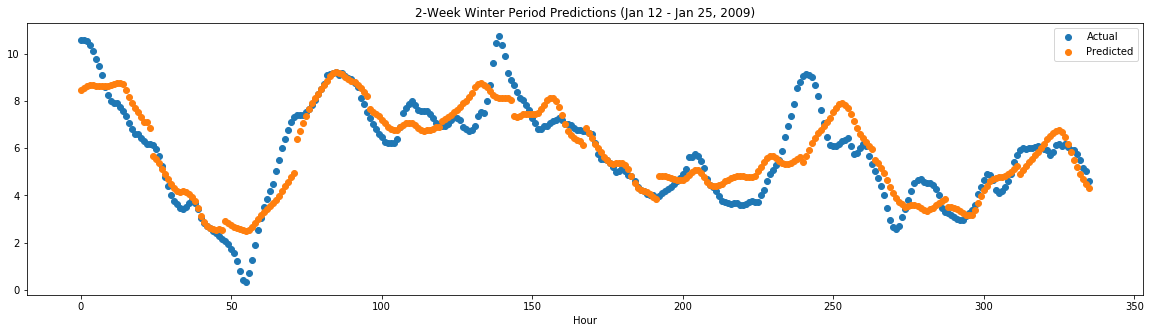

In [57]:
plt.scatter(np.arange(0,14*24,1),y_d14_winter)
plt.scatter(np.arange(0,14*24,1),pred_d14_winter)
plt.xlabel("Hour")
plt.title("2-Week Winter Period Predictions (Jan 12 - Jan 25, 2009)")
plt.legend(["Actual","Predicted"])

### Neural Networks

In [61]:
from sklearn.neural_network import MLPRegressor

nn = MLPRegressor(hidden_layer_sizes=(50, 30, 24), activation='relu', solver='adam', alpha=0.001, batch_size='auto', learning_rate='adaptive', learning_rate_init=0.001).fit(X_train,y_train)
pred_nn = nn.predict(X_test)

In [62]:
# metrics
r2_nn = r2_score(y_test,pred_nn)
mae_nn = mean_absolute_error(y_test,pred_nn)
mse_nn = mean_squared_error(y_test,pred_nn)

print("R2-score: ",r2_nn)
print("MAE-score: ",mae_nn)
print("MSE-score: ",mse_nn)

R2-score:  -0.7069082131091055
MAE-score:  2.1673367322058636
MSE-score:  7.345007806337257


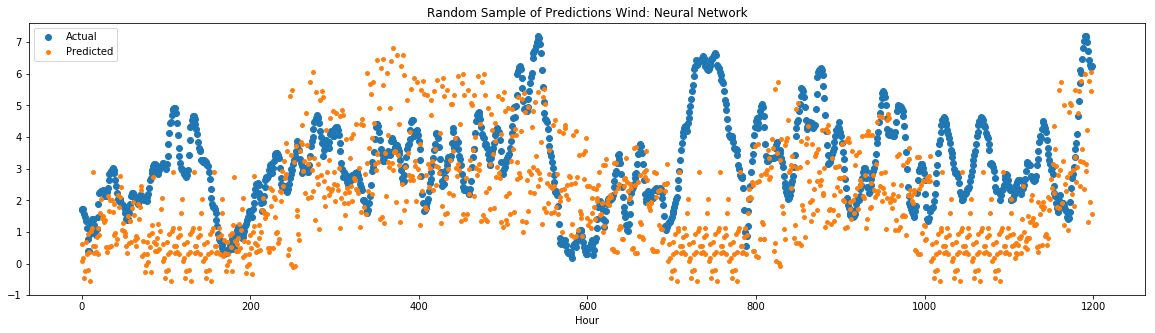

In [63]:
plt.scatter(np.arange(0,50*24,1),y_test.values[4000:4050])
plt.scatter(np.arange(0,50*24,1),pred_nn[4000:4050], s=15)


plt.xlabel("Hour")
plt.title("Random Sample of Predictions Wind: Neural Network")
plt.legend(["Actual","Predicted"])

Clearly the model has issues with the extreme fluctuations of temperatures across the UK in the winter months, with predictions unable to capture the variability of the diurnal cycle. Summer months exhibit a more constant diurnal cycle with much better predictions.

In [64]:
def RMS_based_eval(timeseries_for_eval,field,case_no,method_str):

    ''''
    timeseries_for_eval [array] must be the appropriate length for case study evaluation 
    Case1 = 168 hours
    Case2 = 216 hours
    Case3 = 672 hours
    field [str] must either be 'T2m', 'speed10m' , or 'rsds'
    case no [str] must be either 1,2 or 3.
    method_str [str] what you'd like it referred to as.
    '''
    
    obs = np.loadtxt('/gws/pw/j05/cop26_hackathons/oxford/Group_folders/group_1/case_studies/Case_' + case_no + '_' + field + '.dat')
    
    obs_date = np.load('/gws/pw/j05/cop26_hackathons/oxford/Group_folders/group_1/case_studies/Case_' + case_no + '_date.npy')
    MAE = np.mean(obs - timeseries_for_eval)
    RMS = np.sqrt(np.nanmean((obs - timeseries_for_eval)**2))
    
    fig = plt.figure(figsize=(12,4))
    plt.plot(obs_date,obs,color='k',label='ERA5 obs')
    if field == 'T2m':
        plt.plot(obs_date,timeseries_for_eval,color='r',label=method_str)
        plt.ylabel('2m temperature ($^{o}$C)',fontsize=14)
        plt.title('Case study ' + case_no )
        plt.xlabel('MAE = ' + str(MAE) + ' , RMS = ' + str(RMS))
    if field == 'speed10m':
        plt.plot(obs_date,timeseries_for_eval,color='b',label=method_str)
        plt.ylabel('10m wind speed (ms$^{-1}$)',fontsize=14)
        plt.title('Case study ' + case_no)
    if field == 'rsds':
        plt.plot(obs_date,timeseries_for_eval,color='gold',label=method_str)
        plt.ylabel('Surface shortwave radiation (Wm$^{-2}$)',fontsize=14)
        plt.title('Case study ' + case_no )
    plt.legend(frameon=False)
    plt.show()
    return([MAE, RMS])

In [65]:
# index y_test to determine dates for case studies
from datetime import datetime

days = pd.to_datetime(y_test.index)
index_case1 = np.where((days>=datetime(2019,11,18)) & (days<=datetime(2019,11,24)))
input_case1_reg = pred_reg[index_case1].flatten()
input_case1 = pred_rf[index_case1].flatten()
input_case1nn = pred_nn[index_case1].flatten()


index_case2 = np.where((days>=datetime(2020,7,1)) & (days<=datetime(2020,7,9)))
input_case2_reg = pred_reg[index_case2].flatten()
input_case2 = pred_rf[index_case2].flatten()
input_case2nn = pred_nn[index_case2].flatten()


index_case3 = np.where((days>=datetime(2018,2,20)) & (days<=datetime(2018,3,19)))
input_case3_reg = pred_reg[index_case3].flatten()
input_case3 = pred_rf[index_case3].flatten()
input_case3nn = pred_nn[index_case3].flatten()


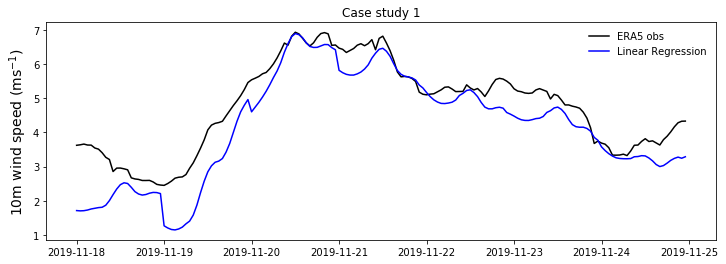

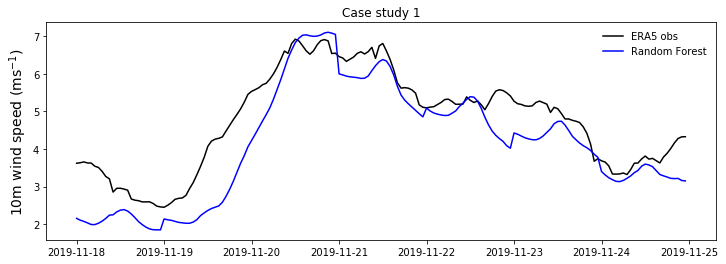

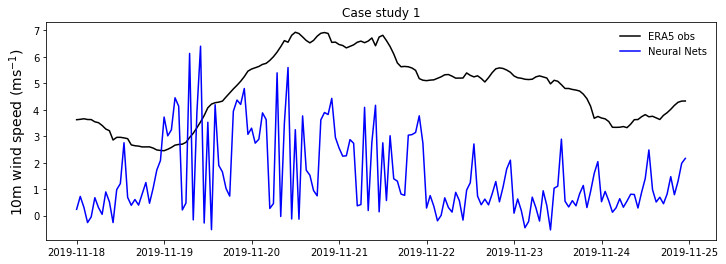

[3.2369904489002295, 3.7031789834110556]

In [68]:
RMS_based_eval(input_case1_reg,"speed10m","1","Linear Regression")
RMS_based_eval(input_case1,"speed10m","1","Random Forest")
RMS_based_eval(input_case1nn,"speed10m","1","Neural Nets")

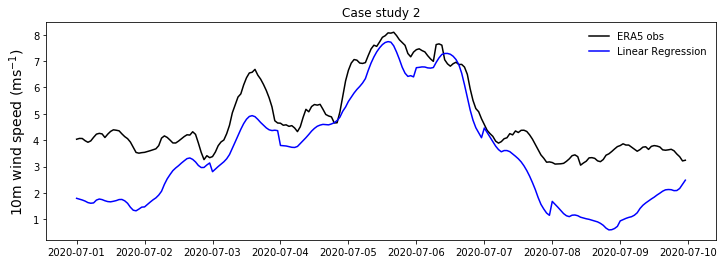

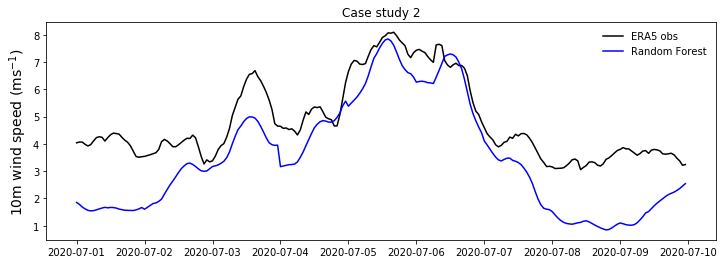

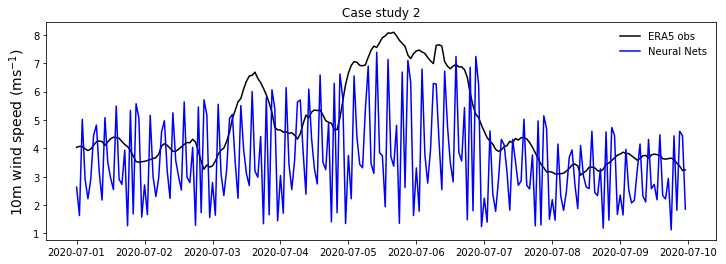

[1.2406071297040253, 2.2047346158982566]

In [69]:
RMS_based_eval(input_case2_reg,"speed10m","2","Linear Regression")
RMS_based_eval(input_case2,"speed10m","2","Random Forest")
RMS_based_eval(input_case2nn,"speed10m","2","Neural Nets")

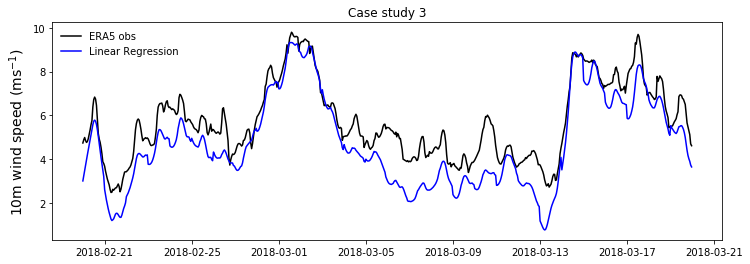

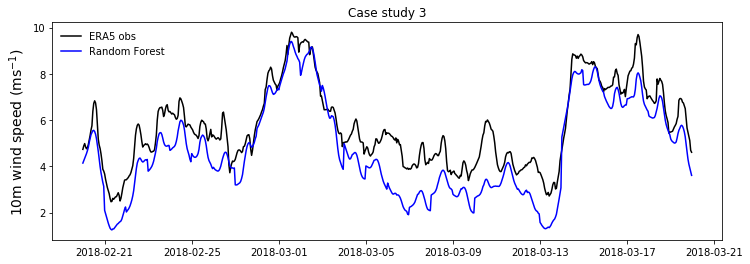

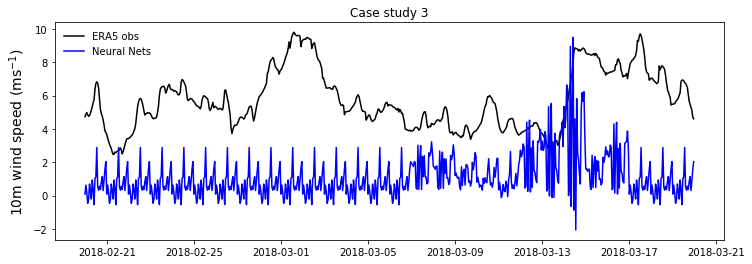

[4.6121310274637946, 5.103118123828772]

In [71]:
RMS_based_eval(input_case3_reg,"speed10m","3","Linear Regression")
RMS_based_eval(input_case3,"speed10m","3","Random Forest")
RMS_based_eval(input_case3nn,"speed10m","3","Neural Nets")

t2m               0.001839
ssrd              0.006947
msl               0.003836
nao               0.004148
w10               0.849074
w100              0.006242
tcc               0.005759
tp                0.006394
week              0.004708
t2mmax            0.002429
t2mmin            0.002838
pc0               0.003002
pc1               0.004461
pc2               0.004908
pc3               0.004772
pc4               0.005307
t2min_previous    0.002734
t2m_previous      0.002464
t2min_next        0.002524
t2m_next          0.002227
w10_previous      0.028318
w10_next          0.031579
pc0_previous      0.001409
pc0_next          0.001345
pc1_previous      0.001373
pc1_next          0.001335
pc2_previous      0.001389
pc2_next          0.001331
pc3_previous      0.001318
pc3_next          0.001327
pc4_previous      0.001363
pc4_next          0.001301
dtype: float64

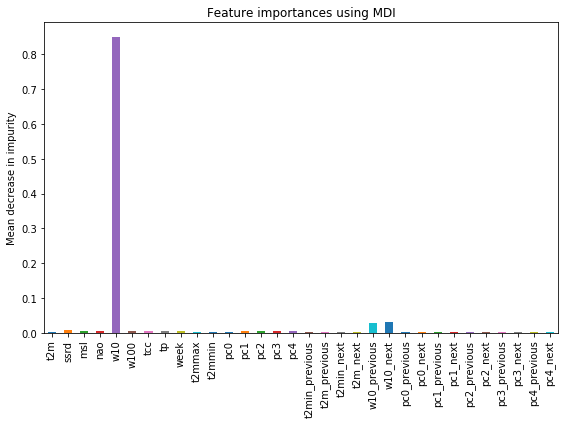

In [72]:
feature_names = X.columns
importances = rf.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in rf.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
forest_importances.plot.bar( ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

forest_importances